In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15676, done.
remote: Counting objects: 100% (399/399), done.
remote: Compressing objects: 100% (305/305), done.
remote: Total 15676 (delta 176), reused 285 (delta 94), pack-reused 15277
Receiving objects: 100% (15676/15676), 6.51 MiB | 6.96 MiB/s, done.
Resolving deltas: 100% (11292/11292), done.


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=7ed026fdb6b35e0776791bcf0a4a93b8a366d90d6c61d414ba11cb248bc7f5ec
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=6d89b1671667add4902bde22d188e9629b0f913cd8e1f9a83555b6a455926a27
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a12

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


from pathlib import Path
import cv2
import matplotlib.pyplot as plt


In [4]:
from gdown import download_folder

def download_public_gdrive_folder(url, local_path):
  """
  Downloads a directory from a public Google Drive URL.

  Args:
    url: The public Google Drive URL of the folder.
    local_path: The local path where the folder will be downloaded.
  """
  # Extract the folder ID from the URL
  folder_id = url.split('/')[-1]
  print(folder_id)
  download_folder(id=folder_id, output=local_path, quiet=False)

In [6]:
mask_rcnn_weights_url = "https://drive.google.com/drive/folders/1j7Mn7EREHOGCKJDk77NRjeRxboUHrEti?usp=sharing"
local_download_path = "/content/mask_rcnn_weights"

download_public_gdrive_folder(mask_rcnn_weights_url, local_download_path)

1j7Mn7EREHOGCKJDk77NRjeRxboUHrEti?usp=sharing


Retrieving folder contents


Retrieving folder 1-UDHDGhWHAoJjsfgk3T6w2PAvVwCADTL output
Processing file 1-erwv9_vmRbOknEHBy1s5NUFLvFDaWa0 coco_instances_results.json
Processing file 1-VNSgpW_L3QyKFht-ViEY1sq0CADmR1V events.out.tfevents.1715590033.913fe913d14b.414.0
Processing file 1-qkaOHRxvy5uFaylzUgsMdP02dVKmjpi instances_predictions.pth
Processing file 1-v7V3sdXHZsQscbHpGCo7-B6akDpf_lo last_checkpoint
Processing file 1-VsgJTrCdDmO9-12mg6AHcKPlNSQXBqP metrics.json
Processing file 1-av2pVjxdowsWsGRTDnwVsiWMU09Y6Cs model_final.pth
Retrieving folder 1--IJjLvXw16ysL26oYZ73YmpAn6OHCKM R50-FPN
Processing file 1-BA651wcvv0qE-l4R7XfQFs_oeZmzvAd coco_instances_results.json
Processing file 1--v76qksBZNWk3bVtOOzD3X9FpOwePKb events.out.tfevents.1715601559.ac531199fd34.190.0
Processing file 1-RxFqfOQVxObfgyzxVrcIX1bbOx-XA_H instances_predictions.pth
Processing file 1-WtTN-dLdmBUu2KTdfPAfS5cUpzClkKE last_checkpoint
Processing file 1--xnHxUBqUD08kZdDUAwFHAPUADOFEPV metrics.json
Processing file 1-74IUGbKWy7hl3XROtIQ8oesoI2fdGVe

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1-erwv9_vmRbOknEHBy1s5NUFLvFDaWa0
To: /content/mask_rcnn_weights/output/coco_instances_results.json
100%|██████████| 61.8k/61.8k [00:00<00:00, 28.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-VNSgpW_L3QyKFht-ViEY1sq0CADmR1V
To: /content/mask_rcnn_weights/output/events.out.tfevents.1715590033.913fe913d14b.414.0
100%|██████████| 28.5k/28.5k [00:00<00:00, 10.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-qkaOHRxvy5uFaylzUgsMdP02dVKmjpi
To: /content/mask_rcnn_weights/output/instances_predictions.pth
100%|██████████| 38.8k/38.8k [00:00<00:00, 39.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-v7V3sdXHZsQscbHpGCo7-B6akDpf_lo
To: /content/mask_rcnn_weights/output/last_checkpoint
100%|██████████| 15.0/15.0 [00:00<00:00, 19.6kB/s]
Downloading...
From: https://drive.google.com/uc?id=1-VsgJTrCdDmO9-12

In [8]:
# Setup config and corresponding own weights
# MASK_RCNN_MODEL = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
MASK_RCNN_MODEL = "/content/mask_rcnn_weights/R101-FPN/config.yaml"

cfg = get_cfg()
cfg.merge_from_file(MASK_RCNN_MODEL) # Config file
cfg.MODEL.WEIGHTS = "/content/mask_rcnn_weights/R101-FPN/ResNet101-FPN.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set a custom testing threshold
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
predictor = DefaultPredictor(cfg)

[05/14 07:07:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/mask_rcnn_weights/R101-FPN/ResNet101-FPN.pth ...


In [9]:
def do_inference_mask_rcnn(image: np.array, predictor):
  # Use the detector to do inference
  result = predictor(image)
  print(result)
  # predictions_data = result.pred_instances
  # masks_torch = predictions_data.masks
  # # print(masks_torch)
  # mask = np.zeros(image.shape)
  # if len(masks_torch > 0):
  #   mask = create_mask_from_inference_mask_rcnn(masks_torch)

  return result

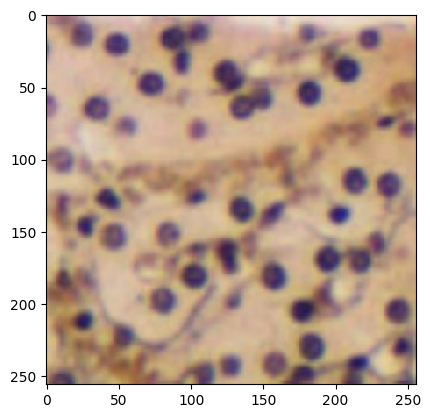

In [11]:
img_path = "/content/pic_cell_nuclei.png"
image = cv2.imread(img_path)
image_cell_nuclei = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR to RGB conversion
plt.imshow(image_cell_nuclei)
plt.show()

In [14]:
res = do_inference_mask_rcnn(image, predictor)
v = Visualizer(image_cell_nuclei[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(res["instances"].to("cpu"))

{'instances': Instances(num_instances=51, image_height=256, image_width=256, fields=[pred_boxes: Boxes(tensor([[ 16.1850,   5.8520,  32.0571,  21.7876],
        [ 45.7076, 214.4952,  60.2831, 229.2818],
        [ 92.6705, 172.5966, 110.2506, 189.3845],
        [ 70.3434, 189.3797,  88.3384, 206.9180],
        [233.8487, 194.9298, 251.3460, 213.7492],
        [ 39.5276,  11.9846,  56.8891,  28.2856],
        [227.8521, 108.5586, 245.0060, 126.0447],
        [173.1892,  46.6034, 189.3726,  62.4374],
        [ 26.0085,  56.9449,  43.7359,  73.0225],
        [ 17.9804, 203.7968,  32.2220, 218.5317],
        [148.9128, 169.8195, 165.3978, 190.4565],
        [ 38.1493, 144.7942,  54.2320, 162.9797],
        [ 97.7500,   5.7730, 111.4674,  19.2308],
        [186.2846, 159.9375, 203.3228, 177.6167],
        [115.5202,  30.6764, 136.2213,  53.3329],
        [117.7544, 154.2900, 132.7845, 178.5647],
        [  6.4640, 176.3092,  17.0876, 188.7070],
        [ 33.9194, 119.9659,  50.3650, 135.2786

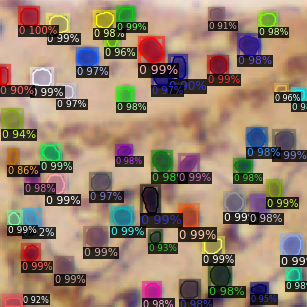

In [16]:
cv2_imshow(out.get_image())

In [20]:
len(res)

1

In [29]:
def create_binary_mask(res):
  instances = res["instances"]
  masks = instances.get("pred_masks")
  masks_numpy = masks.numpy()
  plt.imshow(np.sum(masks_numpy.astype(np.uint8), axis=0), cmap="gray")

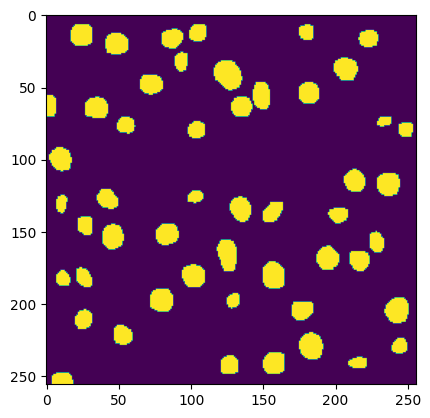

In [30]:
create_binary_mask(res)